In [2]:
import cv2, os

In [9]:
import numpy as np

In [3]:
data_path = 'data'

In [4]:
categories=os.listdir(data_path)
categories

['without_mask', 'with_mask']

In [6]:
labels = [0, 1]
labels

[0, 1]

In [8]:
label_dict = {'without_mask':0, 'with_mask':1}
label_dict

{'without_mask': 0, 'with_mask': 1}

In [25]:
data = []
target = []

for category in categories :
    category_path = os.path.join(data_path, category)
    img_names = os.listdir(category_path)
    
    for img_name in img_names :
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        resized = cv2.resize(img, (100,100))
        np_resized = np.array(resized)
        np_normalized = np_resized/255.0
        np_reshaped = np.reshape(np_normalized, (100,100,3))
        data.append(np_reshaped)
        target.append(label_dict[category])

In [26]:
np.save('data', data)
np.save('target', target)

In [27]:
data = np.load('data.npy')
target = np.load('target.npy')

In [13]:
import matplotlib.pyplot as plt

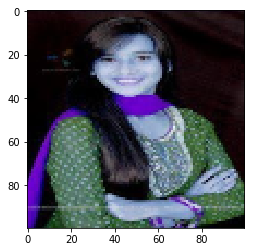

In [29]:
plt.imshow(data[0])
plt.show()

In [30]:
target[0]

0

In [31]:
label_dict

{'without_mask': 0, 'with_mask': 1}

In [35]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

In [40]:
model = Sequential()

model.add(Conv2D(256,(3,3), activation='relu', input_shape=data.shape[1:]))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 256)       7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 67712)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 67712)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [42]:
from sklearn.model_selection import train_test_split

In [67]:
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [44]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)


Train on 990 samples, validate on 248 samples
Epoch 1/20
990/990 [==============================] - 1325s 1s/step - loss: 0.6291 - accuracy: 0.7051 - val_loss: 0.1883 - val_accuracy: 0.9435
Epoch 2/20
990/990 [==============================] - 1316s 1s/step - loss: 0.1870 - accuracy: 0.9364 - val_loss: 0.1071 - val_accuracy: 0.9718
Epoch 3/20
990/990 [==============================] - 1293s 1s/step - loss: 0.0978 - accuracy: 0.9737 - val_loss: 0.1095 - val_accuracy: 0.9677
Epoch 4/20
990/990 [==============================] - 1288s 1s/step - loss: 0.0924 - accuracy: 0.9677 - val_loss: 0.1204 - val_accuracy: 0.9637
Epoch 5/20
990/990 [==============================] - 1290s 1s/step - loss: 0.1049 - accuracy: 0.9697 - val_loss: 0.0862 - val_accuracy: 0.9718
Epoch 6/20
990/990 [==============================] - 1303s 1s/step - loss: 0.0560 - accuracy: 0.9808 - val_loss: 0.0810 - val_accuracy: 0.9758
Epoch 7/20
990/990 [==============================] - 1294s 1s/step - loss: 0.0537 - accu

KeyboardInterrupt: 

In [70]:
model.evaluate(test_data, test_target)

138/138 [==============================] - 113s 821ms/step


[0.02399104034555131, 0.9855072498321533]

In [45]:
from keras.models import load_model

In [63]:
model = load_model('model-008.model')

In [47]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [48]:
source=cv2.VideoCapture(0)

In [51]:
label_dict = {0:'without_mask', 1:'with_mask'}
label_dict

{0: 'without_mask', 1: 'with_mask'}

In [50]:
color_dict = {0:(0,0,255), 1:(0,255,0)}
color_dict

{0: (0, 0, 255), 1: (0, 255, 0)}

In [72]:
while(True) :
    
    boolean, img = source.read()
    print(boolean)
    faces = face_clsfr.detectMultiScale(img,1.3,5)
    
    for (x,y,bottom,h) in faces :
        face_img = img[y:y+w, x:x+w, :]
        resized=cv2.resize(face_img,(100,100,3))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,3))
        result=model.predict(reshaped)
        label = 0
        if(result[0]<0.5) :
            label = 0
        else :
            label = 1
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, label_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27) :
        break

cv2.destroyAllWindows()
source.release()

False


error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1698: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'
